In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.split import temporal_train_test_split

import warnings

from src.config import get_config

warnings.filterwarnings("ignore")

In [2]:
config = get_config()

stations_timeseries = pd.read_csv(config.processed_data_path / 'stations_timeseries.csv', index_col=0, parse_dates=True)
# Set index frequency to hourly
stations_timeseries.index = pd.DatetimeIndex(stations_timeseries.index).to_period('H')
# Keep only column named 90
stations_timeseries = stations_timeseries[['90']]

In [3]:
# Split into train and test
train, test = temporal_train_test_split(stations_timeseries, test_size=0.2)


In [4]:
model = ExponentialSmoothing(sp=24*7, trend='add', seasonal='add')

model.fit(train)

pred = model.predict(fh=test.index).round(0)

<Axes: >

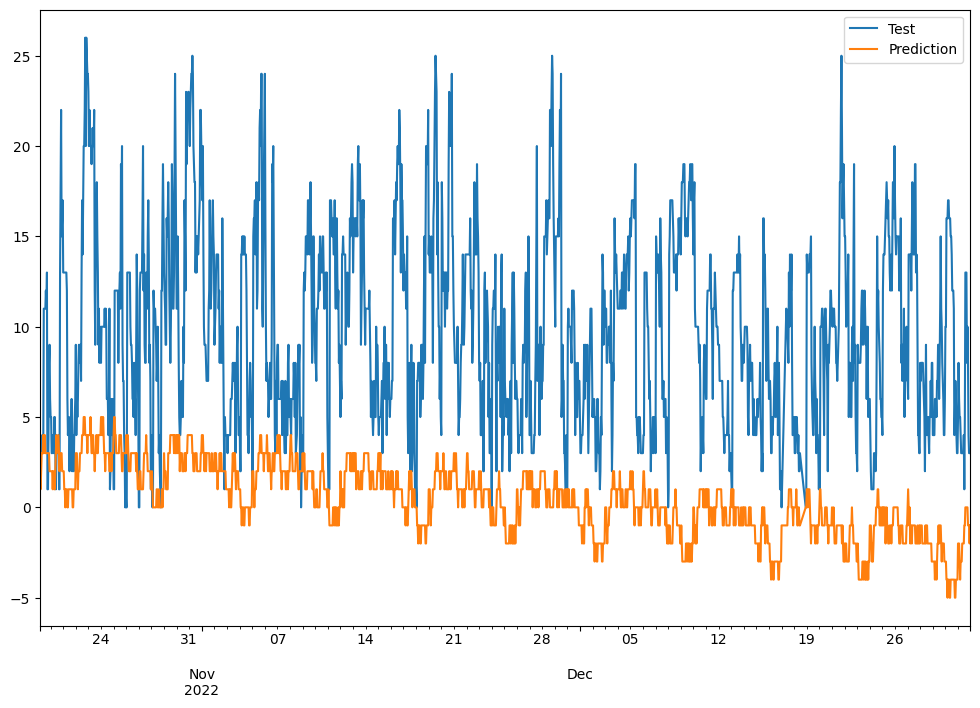

In [6]:
both = pd.concat([test, pred], axis=1)
both.columns = ['Test', 'Prediction']
both.plot(figsize=(12, 8))

In [8]:
model_auto = AutoETS(auto=True, sp=24*7, n_jobs=-1)

model_auto.fit(train)

pred_auto = model_auto.predict(fh=test.index).round(0)

<Axes: xlabel='timestamps'>

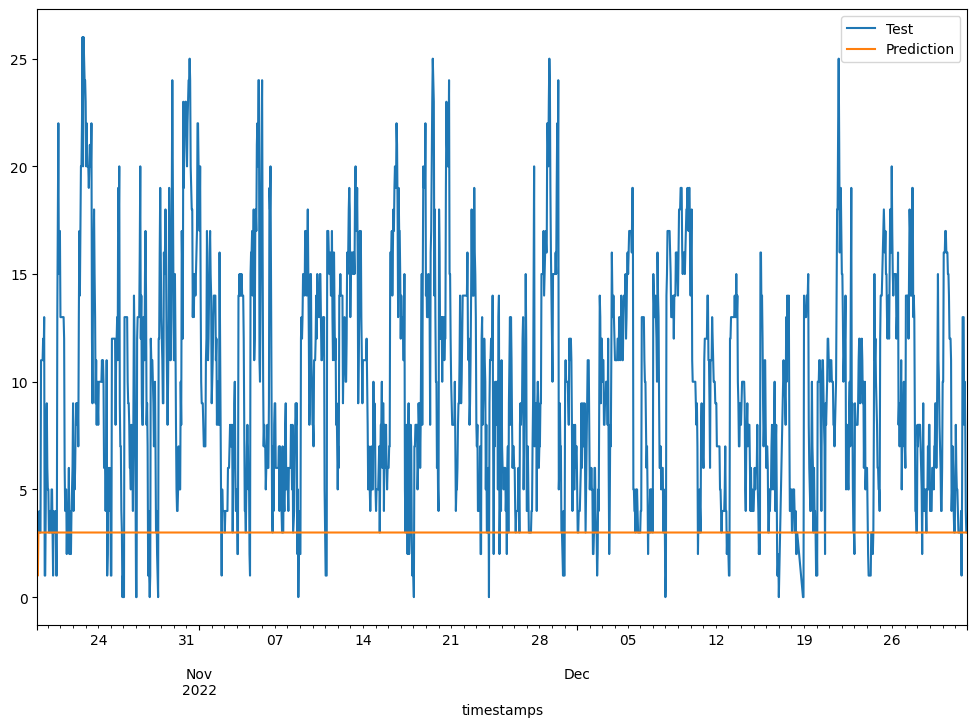

In [9]:
both_auto = pd.concat([test, pred_auto], axis=1)
both_auto.columns = ['Test', 'Prediction']
both_auto.plot(figsize=(12, 8))

<Axes: xlabel='timestamps'>

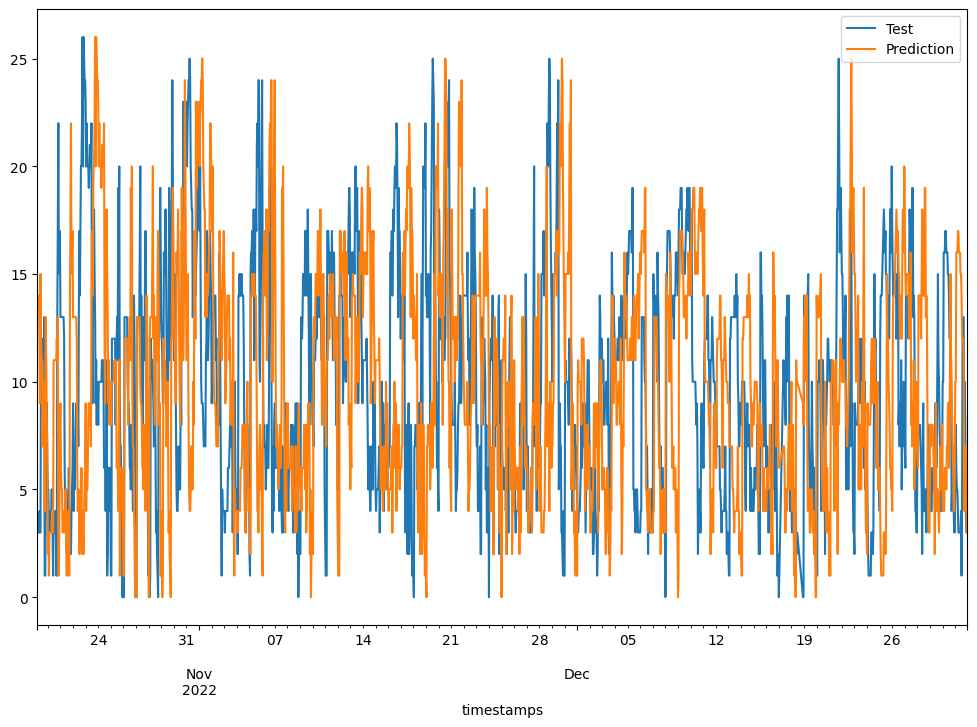

In [23]:
# Use last 24 hours as a predicton of the test set
pred_last_24 = stations_timeseries.shift(24).round(0)[-len(test):]

both_last_24 = pd.concat([test, pred_last_24], axis=1)
both_last_24.columns = ['Test', 'Prediction']
both_last_24.plot(figsize=(12, 8))

In [24]:
pred_last_24['2022-11-02 00:00:00':'2022-11-02 23:00:00']

,90
timestamps,
2022-11-02 00:00,18.0
2022-11-02 01:00,17.0
2022-11-02 02:00,20.0
2022-11-02 03:00,14.0
2022-11-02 04:00,10.0
2022-11-02 05:00,9.0
2022-11-02 06:00,9.0
2022-11-02 07:00,9.0
2022-11-02 08:00,8.0


In [25]:
test['2022-11-01 00:00:00':'2022-11-01 23:00:00']

,90
timestamps,
2022-11-01 00:00,18
2022-11-01 01:00,17
2022-11-01 02:00,20
2022-11-01 03:00,14
2022-11-01 04:00,10
2022-11-01 05:00,9
2022-11-01 06:00,9
2022-11-01 07:00,9
2022-11-01 08:00,8


In [49]:
import numpy as np

def predict_hours(time_series, n, end_date):
    """
    Predicts hours based on the mean of the previous n days and continues predicting until the end_date.

    Parameters:
    - time_series: A pandas Series with datetime index containing the time series data.
    - n: Number of previous days to consider for the mean.
    - end_date: End date until which predictions will be made.

    Returns:
    - A pandas Series with the predicted hours.
    """
    predictions = pd.Series(index=pd.date_range(start=time_series.index[0].to_timestamp(), end=end_date.to_timestamp(), freq='H'))

    for date in predictions.index:
        if date in time_series.index:
            # If the date is in the original time series, use the actual value
            predictions[date] = time_series[date]
        else:
            # Calculate the mean of the previous n days and predict the hour
            previous_n_days = time_series.loc[date - pd.DateOffset(days=n):date - pd.DateOffset(days=1)]
            predictions[date] = pd.mean(previous_n_days)

    return predictions

pred_mean_7 = predict_hours(train, 7, test.index[-1])

KeyError: Timestamp('2022-01-01 00:00:00')

In [47]:
test.index[-1].to_timestamp()

Timestamp('2022-12-31 23:00:00')

In [149]:
def get_n_days_before(df, n, date):
    """
    Returns the date n days before the given date.

    Parameters:
    - date: Date to consider.
    - n: Number of days before the given date.

    Returns:
    - A pandas Timestamp with the date n days before the given date.
    """
    print(date - pd.DateOffset(days=n))
    print(date - pd.DateOffset(days=1))

    return df[date - pd.DateOffset(days=n):date - pd.DateOffset(days=1):24]

def predict_hours(time_series, n, end_date):
    """
    Predicts hours based on the mean of the previous n days and continues predicting until the end_date.

    Parameters:
    - time_series: A pandas Series with datetime index containing the time series data.
    - n: Number of previous days to consider for the mean.
    - end_date: End date until which predictions will be made.

    Returns:
    - A pandas Series with the predicted hours.
    """
    predictions = time_series.copy(deep=True)
    # Convert dataframe to series
    if isinstance(predictions, pd.DataFrame):
        predictions = predictions.squeeze()
    
    date_range = pd.date_range(start=time_series.index[-1].to_timestamp() + pd.DateOffset(hours=1), end=end_date.to_timestamp(), freq='H')

    # Extend the time series with the new dates
    predictions = pd.concat([predictions, pd.Series(index=date_range)])
    print(predictions)
    for date in date_range:
        print(date)
        # Calculate the mean of the previous n days and predict the hour
        print(type(predictions.index[0]))
        previous_n_days = get_n_days_before(predictions, n, date)
        predictions[date] = previous_n_days.mean()

    return predictions

pred_mean_7 = predict_hours(train, 2, test.index[-1])

# Join test and predictions by index
both_mean_7 = pd.concat([test, pred_mean_7], axis=1)
both_mean_7.columns = ['Test', 'Prediction']
both_mean_7.plot(figsize=(12, 8))

2022-01-01 00:00       19.0
2022-01-01 01:00       19.0
2022-01-01 02:00       19.0
2022-01-01 03:00       18.0
2022-01-01 04:00       18.0
                       ... 
2022-12-31 19:00:00     NaN
2022-12-31 20:00:00     NaN
2022-12-31 21:00:00     NaN
2022-12-31 22:00:00     NaN
2022-12-31 23:00:00     NaN
Length: 8762, dtype: float64
2022-10-19 04:00:00
<class 'pandas._libs.tslibs.period.Period'>
2022-10-17 04:00:00
2022-10-18 04:00:00


KeyError: Timestamp('2022-10-17 04:00:00')